# 0. About

**Note -->> Work in Progress**

This notebook is to try to use some supervised PCA.
Currently there is no supervised PCA module in sklearn, so we need to modify the module a little.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import sklearn
from sklearn.datasets import load_diabetes
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, RepeatedKFold, GridSearchCV

import pandas as pd
import seaborn as sns
import scipy
import warnings

rs_num = 42
sklearn.set_config(display="diagram")

In [2]:
# load data
X, y = load_diabetes(return_X_y=True)
sample_num, feature_num = X.shape
print('Sample number: ' + str(sample_num))
print('Feature number: ' + str(feature_num))

Sample number: 442
Feature number: 10


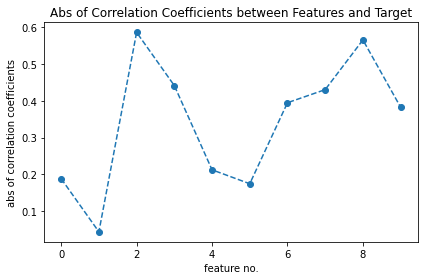

In [3]:
# check dataset correlation coefficients between features and target
corr_coef = np.corrcoef(X.T, y.T)

fig, ax = plt.subplots()

ax.plot(np.abs(corr_coef[:-1, -1]), ls='--', marker='o')
ax.set_xlabel('feature no.')
ax.set_ylabel('abs of correlation coefficients')
ax.set_title('Abs of Correlation Coefficients between Features and Target')

plt.tight_layout()

# 1. Data/Pipeline Setup

We can prepare some classes for the PCA and GPR.
In general, we wish to see how the following variables can change the model prediction:
1. if we apply data standardization transformation
2. if we pre-screen the data with supervised PCA
3. if we change the threshold $\theta$ of the supervised PCA (using GPR 5-fold cross-validation)
4. if we change the threshold of the PCA scree plot after the above pre-processing steps. 

As the evaluation metric, we can use the **5-fold cross-validation scores** from sklearn Gaussian Process Regression (GPR). 
Of course to prevent leaking data into the model, we should split the dataset into **Training Data** and **Test Data**, and apply k-fold cross-validation directly on the **Training Data**, i.e. when calculating mean/std/etc, we only calculate the **Training Data**, as is indicated here: [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)

## 1.1. Customized GPR Class

The GPR class is modified so that we can modify the `maxiter` parameter of the optimizer.

In [4]:
"""
Ref: 
1. For inherit the GPR class:
    https://stackoverflow.com/questions/62376164/
    how-to-change-max-iter-in-optimize-function-used-by-sklearn-gaussian-process-reg
2. For modifiying the __init__:
    https://stackoverflow.com/questions/40025406/inherit-from-scikit-learns-lassocv-model
"""

class MyGPR(GaussianProcessRegressor):
    def __init__(
        self, 
        kernel=None, 
        *, 
        alpha=1e-10, 
        optimizer="fmin_l_bfgs_b", 
        n_restarts_optimizer=0, 
        normalize_y=False, 
        copy_X_train=True, 
        random_state=None, 
        max_iter=1e5, 
        **kwargs
    ):
        self.max_iter = max_iter
        super().__init__(
            kernel=kernel, 
            alpha=alpha, 
            optimizer=optimizer, 
            n_restarts_optimizer=n_restarts_optimizer, 
            normalize_y=normalize_y, 
            copy_X_train=copy_X_train, 
            random_state=random_state, 
            **kwargs
        )
    
    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(
                obj_func, 
                initial_theta, 
                method="L-BFGS-B", 
                jac=True, 
                bounds=bounds, 
                options={'maxiter': self.max_iter}
            )
            sklearn.utils.optimize._check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(
                obj_func, initial_theta, bounds=bounds
            )
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min

## 1.2. Split Data into Training and Test

In [5]:
[X_train, 
 X_test, 
 y_train, 
 y_test] = train_test_split(X, y, test_size=0.20, random_state=rs_num)
X_train.shape

(353, 10)

# 2. Regular PCA

First we need to make a benchmark to see how it goes with the dataset with the regular PCA with standardization.

## 2.1. Scree Plot

We can check out around how many components we may need to have.

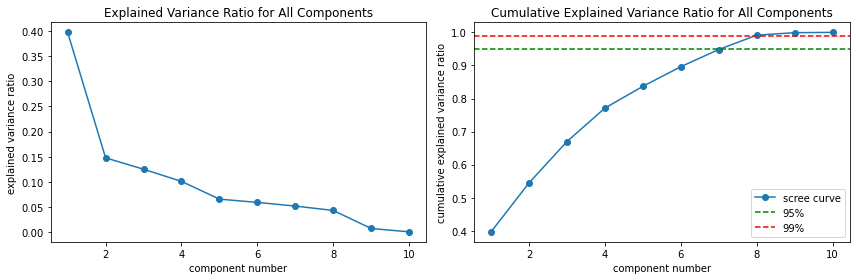

In [6]:
X_train_standardized = StandardScaler().fit_transform(X_train)
regular_pca = PCA(random_state=22).fit(X_train_standardized)

# compute cumulative explained variance ratio
regular_cu_evr = np.zeros_like(regular_pca.explained_variance_ratio_)
for i in range(regular_pca.n_components_):
    regular_cu_evr[i] = regular_pca.explained_variance_ratio_[:i+1].sum()

# visualize explained variance and variance ratio
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(
    np.arange(1, regular_pca.n_components_+1, 1), 
    regular_pca.explained_variance_ratio_, '-o'
)
axes[0].set_xlabel('component number')
axes[0].set_ylabel('explained variance ratio')
axes[0].set_title('Explained Variance Ratio for All Components')

axes[1].plot(
    np.arange(1, regular_pca.n_components_+1, 1), 
    regular_cu_evr, '-o', label='scree curve'
)
axes[1].axhline(y=0.95, color='green', ls='--', label='95%')
axes[1].axhline(y=0.99, color='red', ls='--', label='99%')
axes[1].set_xlabel('component number')
axes[1].set_ylabel('cumulative explained variance ratio')
axes[1].set_title('Cumulative Explained Variance Ratio for All Components')
axes[1].legend()

plt.tight_layout()

We can also check each feature contribution of the first three components.

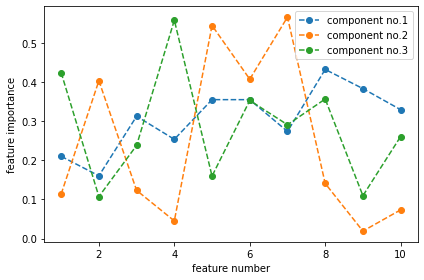

In [7]:
fig, ax = plt.subplots()
for i in range(3):
    ax.plot(
        np.arange(1, regular_pca.n_components_+1, 1), 
        np.abs(regular_pca.components_[i, :]), 
        ls='--', marker='o', label='component no.{:}'.format(i+1)
    )
ax.set_xlabel('feature number')
ax.set_ylabel('feature importance')
ax.legend()

plt.tight_layout()

## 2.2. Hyper-parameter Tuning - Utilize Pipeline and GridSearch

For this section, we use the `Pipeline` and `GridSearch` to find the optimal hyper-parameters.
This is mainly to create us a **performance baseline**, where later we can compare the results with the supervised PCA.

In [8]:
# construct pipeline
pca_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('pca', PCA(random_state=rs_num)), 
        ('gpr', 
         MyGPR(
             kernel=None, 
             random_state=rs_num, 
             max_iter=1e6
         )
        )
    ]
)

In [9]:
# define pca component number list
pca_n_component_list = [None, 0.99, 0.98, 0.95, 0.90, 0.80]

# define gpr kernel list
kernel_list_1 = [
    ConstantKernel(constant_value=3*c)*RBF(length_scale=3*l) 
    for c in np.logspace(-1, 1, 3) 
    for l in np.logspace(-1, 1, 3)
]
kernel_list_2 = [
    ConstantKernel(constant_value=3*c)*RBF(length_scale=3*l)+WhiteKernel(noise_level=3*n)
    for c in np.logspace(-1, 1, 3) 
    for l in np.logspace(-1, 1, 3) 
    for n in np.logspace(-1, 1, 3)
]

In [10]:
# define grid space
pca_param_grid = [
    {
        'pca__n_components': pca_n_component_list, 
        'gpr__kernel': kernel_list_1 + kernel_list_2
    }
]

In [11]:
# ignore warnings for some bad optimization
warnings.filterwarnings('ignore')

# construct grid search cv
pca_gscv = GridSearchCV(
    pca_pipeline, param_grid=pca_param_grid, 
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
)

# training and searching
pca_gscv.fit(X_train, y_train)
print('Done')

# reset warnings
warnings.resetwarnings()

Done


Check out Grid Search CV results:

The best Grid No. selected is: 125
 ->> with estimator: 
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.9, random_state=42)),
                ('gpr',
                 MyGPR(kernel=1.73**2 * RBF(length_scale=0.3) + WhiteKernel(noise_level=30),
                       max_iter=1000000.0, random_state=42))])
 ->> with scoring: 
0.4810952939348409


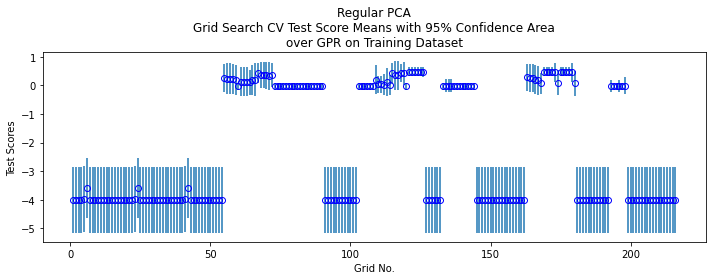

In [23]:
# visualization
fig, ax = plt.subplots(figsize=(10, 4))

ax.errorbar(
    x=np.arange(1, pca_gscv.cv_results_['rank_test_score'].size+1), 
    y=pca_gscv.cv_results_['mean_test_score'], 
    yerr=2*pca_gscv.cv_results_['std_test_score'], 
    ls='None', 
    marker='o', 
    mfc='None', 
    mec='blue'
)

ax.set_title(
    'Regular PCA\n' + 
    'Grid Search CV Test Score Means with 95% Confidence Area\n' + 
    'over GPR on Training Dataset'
)
ax.set_ylabel('Test Scores')
ax.set_xlabel('Grid No.')

plt.tight_layout()

print('The best Grid No. selected is: '+str(pca_gscv.best_index_+1))
print(' ->> with estimator: ')
print(pca_gscv.best_estimator_)
print(' ->> with scoring: ')
print(pca_gscv.best_score_)

With the visualization above, Gaussian Process Regression over this dataset does not have a good performance in general.

# 3. Bair's Supervised Principal Components

The algorithm is documented in the following paper:
[Prediction by Supervised Principal Components](https://doi.org/10.1198/016214505000000628).

The idea is to compute the [**Standard Regression Coefficients**](https://en.wikipedia.org/wiki/Standardized_coefficient) between X and y first, and ignore fetures with low coefficients.

In [14]:
# compute standardized regression coefficients
beta_weights = np.zeros((feature_num, 1))
for feature_i in range(feature_num):
    beta_weights[feature_i, 0] = X[:, feature_i].dot(y.flatten())/np.linalg.norm(X[:, feature_i])

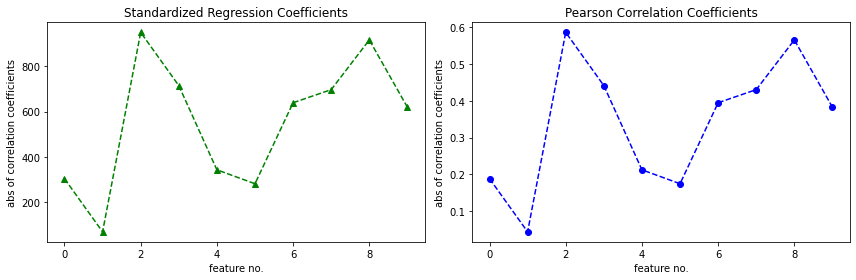

In [15]:
# visualize the coefficients
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Standardized Regression Coefficients
axes[0].plot(np.abs(beta_weights), marker='^', ls='--', color='green')
axes[0].set_xlabel('feature no.')
axes[0].set_ylabel('abs of correlation coefficients')
axes[0].set_title('Standardized Regression Coefficients')

# Pearson Correlation Coefficients
axes[1].plot(np.abs(corr_coef[:-1, -1]), ls='--', marker='o', color='blue')
axes[1].set_xlabel('feature no.')
axes[1].set_ylabel('abs of correlation coefficients')
axes[1].set_title('Pearson Correlation Coefficients')

plt.tight_layout()